In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
# importing all necessary libs and methods

#import os # this library was using in the colab

import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, make_scorer, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from catboost import CatBoostClassifier

In [3]:
SEED = 42 # for reproducibility of the results of the models

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
#base_dir = '/content/drive/MyDrive/Colab Notebooks/DATA'

In [6]:
#data = pd.read_csv(os.path.join(base_dir, 'data.csv'), low_memory=False)
data = pd.read_csv('data.csv') # importing data

In [7]:
# transformation of target feature
data['IncCategory_Binary'] = data['IncCategory$D'].apply(
    lambda x: 1 if x == 'Отчисление' else 0)
data = data.drop(columns=['IncCategory$D'])

In [8]:
# convert data type to datetime
cols_to_date = ['FirstAttemptDate', 'ExamDate', 'LastDate', 'BirthDate']
for col in cols_to_date:
  data[col] = pd.to_datetime(data[col], errors='coerce')

In [9]:
# remove duplicate features
data = data.drop(columns=['RegDepartment$D_y', 'IsBudget_y',
                          'AdmissionYear$N_y', 'Class$D_y', 'Region$D_y',
                          'LearnProgram$D_y', 'Speciality$D_y', 'Class$D_x',
                          'IncomeReason$N', 'RegDepartment$D_x',
                          'StudentClass$D', 'QuitReasonRef$D', 'GradFaculty$D',
                          'GradRegDepartment$D', 'FirstTenScaleMark',
                          'FirstStrResult', 'FirstAttemptDate', 'FirstMissed',
                          'FirstTestMark', 'Faculty$D', 'PrevQualName'])

In [10]:
# replacing values
data['StrResult'] = data['StrResult'].replace({
    "н/я": -1,
    "н/я (ув.)": -2,
    "нет оценки": -3,
    "-": -4
})
data['StrResult'] = pd.to_numeric(data['StrResult'], errors='coerce')

In [11]:
# function to find the mode or the first value if it doesn't exist
def mode_or_first(series):
    modes = series.mode()
    for mode_value in modes:
        if mode_value != "-" and (not isinstance(mode_value, (int, float)) or mode_value >= 0):
            return mode_value
    return series.iloc[0] if not series.empty else None

In [12]:
# grouping data with their aggregation by students
student_data = data.groupby('CS_new').agg({
    'AdmissionYear$N_x': mode_or_first,
    'IsBudget_x': mode_or_first,
    'Speciality$D_x': mode_or_first,
    'Group$D': mode_or_first,
    'Region$D_x': mode_or_first,
    'Country$D': mode_or_first,
    'SubjectType$D': mode_or_first,
    'PlanCourse$N': mode_or_first,
    'SubjectClass$D': mode_or_first,
    'LongName': mode_or_first,
    'ControlType$D': mode_or_first,
    'RegDepartment$N': mode_or_first,
    'MarkSumm': mode_or_first,
    'Средняя_оценка': mode_or_first,
    'Не_сдано': mode_or_first,
    'Сдано': mode_or_first,
    'Неуды': mode_or_first,
    'Удовл': mode_or_first,
    'Хор': mode_or_first,
    'Отл': mode_or_first,
    'StrResult': ['mean', mode_or_first, 'min', 'max'],
    'Missed': ['mean', mode_or_first, 'min', 'max'],
    'TestMark': ['mean', mode_or_first, 'min', 'max'],
    'TenScaleMark': ['mean', mode_or_first, 'min', 'max'],
    'RepassCount': mode_or_first,
    'HasFail': ['mean', mode_or_first, 'min', 'max'],
    'Sex (1-мужской)': mode_or_first,
    'BirthDate': mode_or_first,
    'ChargedOlympList': mode_or_first,
    'MagAbitCategory$D': mode_or_first,
    'Faculty$N': mode_or_first,
    'LearnForm$D': mode_or_first,
    'University$D': mode_or_first,
    'HigherDocSpec$D': mode_or_first,
    'AverPrevMark': ['mean', mode_or_first, 'min', 'max'],
    'PlaceType$D': mode_or_first,
    'КР_сумма': ['mean', mode_or_first, 'min', 'max'],
    'IncCategory_Binary': mode_or_first
}).reset_index()

In [13]:
# getting rid of multi-index
student_data.columns = ['_'.join(col).strip() \
                        if isinstance(col, tuple) \
                            else col for col in student_data.columns]

In [14]:
# putting column names in order after grouping
student_data.columns = ['CS_new', 'AdmissionYear', 'IsBudget', 'Speciality',
                        'Group', 'Region', 'Country', 'SubjectType',
                        'PlanCourse', 'SubjectClass', 'LongName',
                        'ControlType', 'RegDepartment', 'MarkSumm',
                        'AverageGrade', 'FailedGrade', 'PassedGrade', 'Failures',
                        'Satisfactory', 'Good', 'Excellent', 'StrResult_mean',
                        'StrResult_mode', 'StrResult_min', 'StrResult_max',
                        'Missed_mean', 'Missed_mode', 'Missed_min',
                        'Missed_max', 'TestMark_mean', 'TestMark_mode',
                        'TestMark_min', 'TestMark_max', 'TenScaleMark_mean',
                        'TenScaleMark_mode', 'TenScaleMark_min',
                        'TenScaleMark_max','RepassCount', 'HasFail_mean',
                        'HasFail_mode', 'HasFail_min', 'HasFail_max',
                        'Sex', 'BirthDate', 'ChargedOlympList',
                        'MagAbitCategory', 'Faculty', 'LearnForm',
                        'PrevUniversity', 'HigherDocSpec', 'AverPrevMark_mean',
                        'AverPrevMark_mode', 'AverPrevMark_min',
                        'AverPrevMark_max', 'PlaceType', 'Tests_sum_mean',
                        'Tests_sum_mode', 'Tests_sum_min', 'Tests_sum_max',
                        'IncCategory']

In [15]:
# remove extra column
student_data = student_data.drop(columns='BirthDate')

In [16]:
student_data.head()

,CS_new,AdmissionYear,IsBudget,Speciality,Group,Region,Country,SubjectType,PlanCourse,SubjectClass,LongName,ControlType,RegDepartment,MarkSumm,AverageGrade,FailedGrade,PassedGrade,Failures,Satisfactory,Good,Excellent,StrResult_mean,StrResult_mode,StrResult_min,StrResult_max,Missed_mean,Missed_mode,Missed_min,Missed_max,TestMark_mean,TestMark_mode,TestMark_min,TestMark_max,TenScaleMark_mean,TenScaleMark_mode,TenScaleMark_min,TenScaleMark_max,RepassCount,HasFail_mean,HasFail_mode,HasFail_min,HasFail_max,Sex,ChargedOlympList,MagAbitCategory,Faculty,LearnForm,PrevUniversity,HigherDocSpec,AverPrevMark_mean,AverPrevMark_mode,AverPrevMark_min,AverPrevMark_max,PlaceType,Tests_sum_mean,Tests_sum_mode,Tests_sum_min,Tests_sum_max,IncCategory
0,77407,2020,1,Психология,МСП201,Москва,Российская Федерация,Предмет по выбору,1 курс,Дисциплина,Кросс-культурная психология организационного п...,Экзамен,Москва,71.0,8.073333,0.0,22.0,0.0,0.0,5.0,17.0,8.307692,8,7,10,1.961538,2.0,1.0,2.0,1.000000,1.0,1.0,1.0,8.307692,8.0,7.0,10.0,0.0,0.000000,0.0,0.0,0.0,0.0,-,выпускник другого ВУЗа,М факультет социальных наук,очная форма обучения,Torrens University,-,-1.0,-1.0,-1.0,-1.0,Коммерческие места,736.15,736.15,736.15,736.15,0
1,85609,2018,0,Градостроительство,-,Москва,Российская Федерация,Обязательный предмет,1 курс,Дисциплина,Аналитическое чтение по урбанистике,Экзамен,Москва,75.0,0.000000,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0,0,0,2.000000,2.0,2.0,2.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,1.000000,1.0,1.0,1.0,0.0,-,выпускник другого ВУЗа,М Высшая школа урбанистики имени А.А. Высоковс...,очная форма обучения,"Национальный исследовательский университет ""Вы...",-,-1.0,-1.0,-1.0,-1.0,Коммерческие места,0.00,0.00,0.00,0.00,0
2,224509,2019,0,Прикладная математика и информатика,-,Москва,Российская Федерация,Обязательный предмет,1 курс,Дисциплина,Научно-исследовательский семинар,Экзамен,Москва,87.0,6.347500,0.0,22.0,0.0,6.0,7.0,8.0,6.681818,10,0,10,2.000000,2.0,2.0,2.0,0.954545,1.0,0.0,1.0,6.681818,10.0,0.0,10.0,0.0,0.181818,0.0,0.0,1.0,1.0,-,выпускник другого ВУЗа,М факультет компьютерных наук,очная форма обучения,Финансовый университет при Правительстве РФ,Финансы и кредит,-1.0,-1.0,-1.0,-1.0,Коммерческие места,1046.20,1046.20,1046.20,1046.20,0
3,250288,2018,1,Юриспруденция,-,Республика Татарстан,Российская Федерация,Обязательный предмет,1 курс,Дисциплина,"История политических, правовых и религиозных у...",Экзамен,Москва,95.0,7.886667,0.0,18.0,0.0,2.0,7.0,9.0,7.500000,9,4,10,2.000000,2.0,2.0,2.0,1.000000,1.0,1.0,1.0,7.500000,9.0,4.0,10.0,0.0,0.055556,0.0,0.0,1.0,1.0,-,выпускник другого ВУЗа,М Высшая школа юриспруденции и администрирования,очная форма обучения,Московский педагогический государственный унив...,Русский язык и литература,-1.0,-1.0,-1.0,-1.0,Бюджетные места,530.00,530.00,530.00,530.00,0
4,261526,2019,0,История,-,Москва,Российская Федерация,Обязательный предмет,1 курс,Дисциплина,"Естественнонаучные методы в археологии, физиче...",Экзамен,Москва,87.0,8.750000,0.0,16.0,0.0,0.0,2.0,14.0,8.750000,9,6,10,2.000000,2.0,2.0,2.0,1.000000,1.0,1.0,1.0,8.750000,9.0,6.0,10.0,0.0,0.000000,0.0,0.0,0.0,0.0,-,выпускник другого ВУЗа,М факультет гуманитарных наук,очная форма обучения,"МГУ им М.В. Ломоносова, филиал в Ташкенте",БИОЛОГИЧЕСКИЕ НАУКИ,-1.0,-1.0,-1.0,-1.0,Коммерческие места,554.54,554.54,554.54,554.54,0


In [17]:
# create a variable responsible for categorical features
categorical_features = student_data.select_dtypes(
    include=['object', 'category']
    ).columns.tolist()

In [18]:
# encoding categorical features using OHE
student_data_encoded = pd.get_dummies(student_data,
                                      columns=categorical_features,
                                      drop_first=True)

In [19]:
# splitting the dataset into dependent (y) and independent (X) variables
X = student_data_encoded.drop(columns=['IncCategory', 'CS_new'])
y = student_data_encoded['IncCategory']

# divide the samples into training and testing
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y)

### Logistic Regression

In [20]:
# create a scaling object
scaler = StandardScaler()

# create a logistic regression object
logreg = LogisticRegression(solver='liblinear', random_state=SEED)

# hyperparameter grid
param_grid = {
    'logreg__C': [0.01, 0.1, 1, 10, 100], # regularization strength
    'logreg__penalty': ['l1', 'l2'] # type of penalty
}

# pipeline for sequential application of functions
pipeline = Pipeline([
    ('scaler', scaler),
    ('logreg', logreg)
])

# metric calculation function
scorer = make_scorer(roc_auc_score, needs_proba=True)

# object for hyperparameter selection
grid_search_lr = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

# selection of hyperparameters on the training sample
grid_search_lr.fit(X_train, y_train)

# fixing the best result
best_logreg = grid_search_lr.best_score_

# output the best hyperparameters and the best result
print(f'Best hyperparameters: {grid_search_lr.best_params_}')
print(f'Best score: {round(best_logreg, 5)}')

# all subsequent models are designed according to the same logic
# so I did not add comments to them

C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best hyperparameters: {'logreg__C': 0.01, 'logreg__penalty': 'l2'}
Best score: 0.65378


### K-nearest neighbors

In [21]:
scaler = StandardScaler()

knn = KNeighborsClassifier()

param_grid = {
    'knn__n_neighbors': [7, 9, 11],  # number of neighbors
    'knn__weights': ['uniform', 'distance'],  # scale options
    'knn__p': [1, 2]  # distance type: 1 - Manhattan, 2 - Euclidean
}

pipeline = Pipeline([
    ('scaler', scaler),
    ('knn', knn)
])

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_knn = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

grid_search_knn.fit(X_train, y_train)

best_knn = grid_search_knn.best_score_

print(f'Best hyperparameters: {grid_search_knn.best_params_}')
print(f'Best score: {round(best_knn, 5)}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best hyperparameters: {'knn__n_neighbors': 9, 'knn__p': 1, 'knn__weights': 'distance'}
Best score: 0.60096


### Decision Tree Classifier

In [22]:
scaler = StandardScaler()

decision_tree = DecisionTreeClassifier(random_state=SEED)

param_grid = {
    'decision_tree__max_depth': [3, 5, 7], # maximum tree depth
    'decision_tree__min_samples_split': [3, 5, 8],  # minimum samples to split a node
    'decision_tree__min_samples_leaf': [2, 4, 6]  # minimum samples in leaf
}

pipeline = Pipeline([
    ('scaler', scaler),
    ('decision_tree', decision_tree)
])

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_tree = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

grid_search_tree.fit(X_train, y_train)

best_tree = grid_search_tree.best_score_

print(f'Best hyperparameters: {grid_search_tree.best_params_}')
print(f'Best score: {round(best_tree, 5)}')

Fitting 5 folds for each of 27 candidates, totalling 135 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best hyperparameters: {'decision_tree__max_depth': 3, 'decision_tree__min_samples_leaf': 6, 'decision_tree__min_samples_split': 3}
Best score: 0.60534


### Random Forest Classifier

In [23]:
scaler = StandardScaler()

random_forest = RandomForestClassifier(random_state=SEED)

param_grid = {
    'random_forest__n_estimators': [100, 200, 300],  # number of trees
    'random_forest__max_depth': [10, 15],  # maximum depth
    'random_forest__min_samples_split': [5, 10, 20], # minimum samples to split a node
    'random_forest__min_samples_leaf': [1, 2]  # minimum samples in leaf
}

pipeline = Pipeline([
    ('scaler', scaler),
    ('random_forest', random_forest)
])

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_forest = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

grid_search_forest.fit(X_train, y_train)

best_forest = grid_search_forest.best_score_

print(f'Best hyperparameters: {grid_search_forest.best_params_}')
print(f'Best score: {round(best_forest, 5)}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best hyperparameters: {'random_forest__max_depth': 10, 'random_forest__min_samples_leaf': 1, 'random_forest__min_samples_split': 10, 'random_forest__n_estimators': 100}
Best score: 0.86086


### Gradient Boosting Classifier

In [24]:
scaler = StandardScaler()

gb_clf = GradientBoostingClassifier(random_state=SEED)

param_grid = {
    'gb_clf__n_estimators': [50, 100, 200],  # number of trees
    'gb_clf__learning_rate': [0.01, 0.1],  # learning rate
    'gb_clf__max_depth': [3, 5, 7],  # maximum tree depth
    'gb_clf__min_samples_split': [5, 10],  # minimum samples to split a node
    'gb_clf__min_samples_leaf': [2, 4]  # minimum samples in leaf
}

pipeline = Pipeline([
    ('scaler', scaler),
    ('gb_clf', gb_clf)
])

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_gbc = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=2, n_jobs=-1)

grid_search_gbc.fit(X_train, y_train)

best_gb = grid_search_gbc.best_score_

print(f'Best hyperparameters: {grid_search_gbc.best_params_}')
print(f'Best score: {round(best_gb, 5)}')

Fitting 5 folds for each of 72 candidates, totalling 360 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best hyperparameters: {'gb_clf__learning_rate': 0.01, 'gb_clf__max_depth': 3, 'gb_clf__min_samples_leaf': 4, 'gb_clf__min_samples_split': 5, 'gb_clf__n_estimators': 100}
Best score: 0.873


### XGBoost Classifier

In [25]:
scaler = StandardScaler()

xgb_clf = xgb.XGBClassifier(random_state=SEED, use_label_encoder=False, eval_metric='logloss')

param_grid = {
    'xgb_clf__n_estimators': [100, 200],  # number of trees
    'xgb_clf__learning_rate': [0.01, 0.1],  # learning rate
    'xgb_clf__max_depth': [3, 5],  # maximum tree depth
    'xgb_clf__subsample': [0.8, 1.0],  # sample fraction for each tree
    'xgb_clf__colsample_bytree': [0.8, 1.0],  # share of features for each tree
    'xgb_clf__gamma': [0.1, 0.2],  # minimum loss reduction for node splitting
}

pipeline = Pipeline([
    ('scaler', scaler),
    ('xgb_clf', xgb_clf)
])

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_xgb = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

grid_search_xgb.fit(X_train, y_train)

best_xgb = grid_search_xgb.best_score_

print(f'Best hyperparameters: {grid_search_xgb.best_params_}')
print(f'Best score: {round(best_xgb, 5)}')

Fitting 5 folds for each of 64 candidates, totalling 320 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:158: UserWarning: [08:46:36] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Best hyperparameters: {'xgb_clf__colsample_bytree': 0.8, 'xgb_clf__gamma': 0.2, 'xgb_clf__learning_rate': 0.01, 'xgb_clf__max_depth': 3, 'xgb_clf__n_estimators': 100, 'xgb_clf__subsample': 0.8}
Best score: 0.89525


### CatBoost Classifier

In [26]:
catboost_clf = CatBoostClassifier(
    silent=True,  # Отключаем вывод в лог
    random_state=SEED
)

param_grid = {
    'n_estimators': [100, 200],  # number of trees
    'learning_rate': [0.01, 0.1, 0.2],  # learning rate
    'depth': [4, 6, 8],  # tree depth
    'l2_leaf_reg': [1, 3],  # L2 regularization coefficient
    'border_count': [32, 64, 128]  # number of splits for numerical features
}

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_cat = GridSearchCV(catboost_clf, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

grid_search_cat.fit(X_train, y_train)

best_catboost = grid_search_cat.best_score_

print(f'Best hyperparameters: {grid_search_cat.best_params_}')
print(f'Best score: {round(best_catboost, 5)}')

Fitting 5 folds for each of 108 candidates, totalling 540 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best hyperparameters: {'border_count': 128, 'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.2, 'n_estimators': 200}
Best score: 0.83638


### Support Vector Machine (SVM)

In [27]:
scaler = StandardScaler()
svm = SVC(probability=True, random_state=SEED)

param_grid = {
    'svm__C': [0.1, 1, 10],  # regularization parameter
    'svm__kernel': ['linear', 'rbf', 'poly'],  # kernel type
    'svm__gamma': ['scale', 'auto'], # kernel parameter for 'rbf' and 'poly'
    'svm__degree': [2, 3]  # degree of polynomial for kernel 'poly'
}

pipeline = Pipeline([
    ('scaler', scaler),
    ('svm', svm)
])

scorer = make_scorer(roc_auc_score, needs_proba=True)

grid_search_svm = GridSearchCV(pipeline, param_grid,
                           cv=5, scoring=scorer,
                           verbose=1, n_jobs=-1)

grid_search_svm.fit(X_train, y_train)

best_svm = grid_search_svm.best_score_

print(f'Best hyperparameters: {grid_search_svm.best_params_}')
print(f'Best score: {round(best_svm, 5)}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits


C:\Users\Олег\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(


Best hyperparameters: {'svm__C': 1, 'svm__degree': 2, 'svm__gamma': 'auto', 'svm__kernel': 'rbf'}
Best score: 0.65935


In [28]:
# create a dictionary with methods and their metric values ​​(best_XXX)
results = {
    'Метод': ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 
              'XGBoost', 'CatBoost', 'SVM'],
    'Значение метрики': [best_logreg, best_knn, best_tree, best_forest, best_gb, 
                         best_xgb, best_catboost, best_svm]
}

# create a DataFrame
df_results = pd.DataFrame(results)

# sort the DataFrame in descending order of the metric value
df_results_sorted = df_results.sort_values(by='Значение метрики', ascending=False)

# display the table
print(df_results_sorted)

                 Метод  Значение метрики
5              XGBoost          0.895250
4    Gradient Boosting          0.873000
3        Random Forest          0.860857
6             CatBoost          0.836381
7                  SVM          0.659349
0  Logistic Regression          0.653777
2        Decision Tree          0.605336
1                  KNN          0.600956


In [29]:
# predict probabilities for the positive class
y_pred_proba = grid_search_xgb.best_estimator_.predict_proba(X_test)[:, 1]

# we calculate the metric by comparing the predicted and actual values
roc_auc = roc_auc_score(y_test, y_pred_proba)

print(f'ROC AUC on test data: {roc_auc:.5f}')

ROC AUC on test data: 0.85390


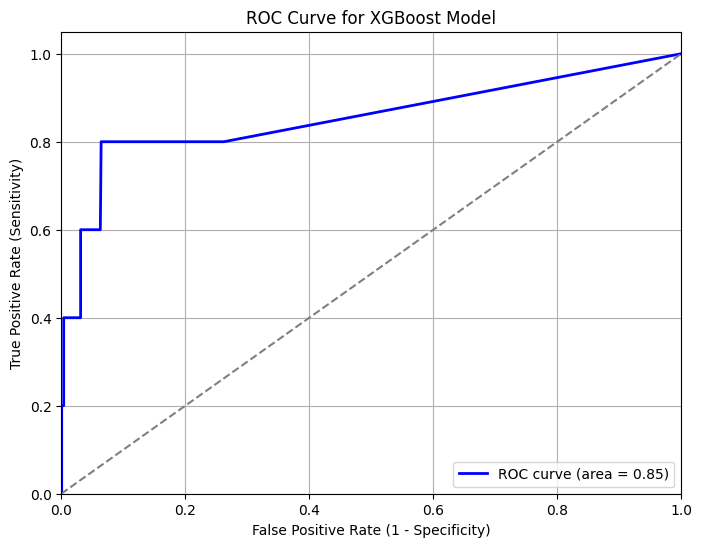

In [30]:
# building a ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# plotting a graph
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # random prediction line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('ROC Curve for XGBoost Model')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [31]:
# get feature importance from XGBClassifier
xgb_model = grid_search_xgb.best_estimator_.named_steps['xgb_clf']

# We get a list of features that the model used
encoded_feature_names = student_data_encoded.columns

# create a DataFrame for only those features that were used by the model
importance_df = pd.DataFrame({
    'Feature': encoded_feature_names[:len(xgb_model.feature_importances_)],
    'Importance': xgb_model.feature_importances_
})

# sort by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

print(importance_df.head(10))

                                                Feature  Importance
18                                           Missed_max    0.082235
27                                          RepassCount    0.065574
12                                       StrResult_mode    0.063528
1504  Faculty_М факультет городского и регионального...    0.046332
62                               Speciality_Политология    0.034942
13                                        StrResult_min    0.032629
3                                              MarkSumm    0.030898
4070                            HigherDocSpec_Логопедия    0.029458
1                                         AdmissionYear    0.029447
9                                                  Good    0.028644


In [32]:
# save the model for further use
xgb_model.save_model('xgb_model.json')

In [33]:
# (optional) load the resulting model to make sure 
# it was saved correctly and there are no errors
best_xgb_model = xgb.XGBClassifier()
best_xgb_model.load_model('xgb_model.json')